# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = './traffic-signs-data/train.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = max(y_train) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

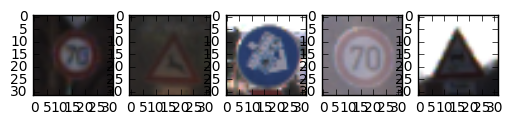

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# plot 5 random signs
import random
for i in range(1,6):
    plt.subplot(150 + i)
    plt.imshow(X_train[int(n_train*random.random())])

<Container object of 43 artists>

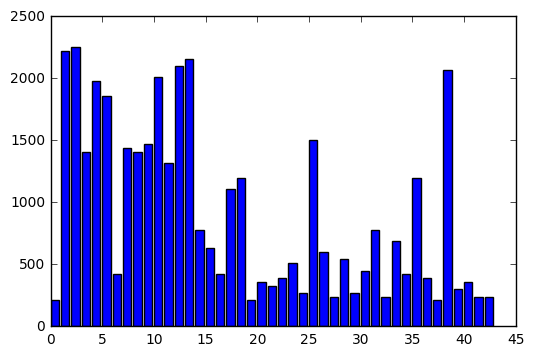

In [5]:
#plot bar graph for count of each sign type in training set
class_count = np.zeros(n_classes)
for c in y_train:
    class_count[c] = class_count[c] + 1
plt.bar(range(n_classes),class_count)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def normalize_greyscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a=0.1
    b=0.9
    x_min=0.
    x_max=255.
    image_data=image_data.astype('float_')
    #print('size is: ',image_data.size)
    for n in np.nditer(image_data,op_flags=['readwrite']):
        n[...] = a + (((n-x_min)*(b-a))/(x_max-x_min))
    # ToDo: Implement Min-Max scaling for greyscale image data
    return image_data

def convert_to_grayscale_and_normalize(feature_set):
    feature_set = [normalize_greyscale(grayscale(features)) for features in feature_set]
    return feature_set

[[ 0.34156863  0.33843137  0.36352941 ...,  0.32588235  0.31333333
   0.31019608]
 [ 0.36039216  0.35098039  0.36980392 ...,  0.33843137  0.33843137
   0.34784314]
 [ 0.34784314  0.36352941  0.37921569 ...,  0.32901961  0.33215686
   0.34470588]
 ..., 
 [ 0.50156863  0.4827451   0.46078431 ...,  0.39803922  0.41372549
   0.41686275]
 [ 0.39176471  0.40117647  0.36666667 ...,  0.42313725  0.44196078
   0.41372549]
 [ 0.36666667  0.40745098  0.34156863 ...,  0.41686275  0.41058824
   0.39490196]]


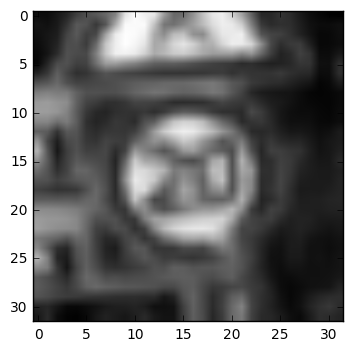

In [7]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

#convert data to greyscale
X_train_norm = convert_to_grayscale_and_normalize(X_train)
X_test_norm = convert_to_grayscale_and_normalize(X_test)
print(X_train_norm[0])
plt.imshow(X_train_norm[0], cmap='gray')

In [8]:
#need to one-hot encode labels, then split training and testing sets and pickle data
from sklearn.preprocessing import LabelBinarizer

# Turn labels into numbers and apply One-Hot Encoding
encoder = LabelBinarizer()
encoder.fit(y_train)
train_labels = encoder.transform(y_train)
test_labels = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)



### Question 1 

_Describe the techniques used to preprocess the data._


**Answer:**

- Data was converted to grayscale as sign type should be (mostly) invariant to color, this enables me to use a lower complexity model
- Data pixel values were normalized using min-max scaling to values between 0.1 - 0.9, to enable more efficent gradient descent while solving for optimal parameter values
- Labels were 1-hot encoded

In [9]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

import os
from sklearn.model_selection import train_test_split
# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    X_train_norm,
    train_labels,
    test_size=0.05,
    random_state=832289)

# Save the data for easy access
pickle_file = 'traffic_sign_data.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('traffic-signs-data.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_features,
                    'train_labels': train_labels,
                    'valid_dataset': valid_features,
                    'valid_labels': valid_labels,
                    'test_dataset': X_test_norm,
                    'test_labels': test_labels,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

My training and validation sets were generated from the data in the provided train.p dataset. The training set is a random 95% of that dataset, while the validation set is the remaining random 5%. I chose to use 5% of the data for the validation set as that was the percentage that we used in the lab at the end of lesson 8. I am using the provided test.p dataset as the testing data.

I am passing the training data to the optimizer and use the validation data to track the progress of the optimizer and tune the various hyperparameters. After I am done optimizing the model, I use the test data to get a sense of how the model will perform in the real world

In [10]:
# Load the modules
import pickle
import math

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Load the data
pickle_file = 'traffic-signs-data.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  train_features = pickle_data['train_dataset']
  train_labels = pickle_data['train_labels']
  valid_features = pickle_data['valid_dataset']
  valid_labels = pickle_data['valid_labels']
  test_features = pickle_data['test_dataset']
  test_labels = pickle_data['test_labels']
  del pickle_data  # Free up memory


print('Data and modules loaded.')

Data and modules loaded.


In [11]:
# Define CNN Helper functions

n_input = 1024  # traffic sign data input (Shape: 32*32)
n_classes = 43  # total number of traffic sign classes

layer_width = {
    'layer_1': 32,
    'layer_2': 64,
    'layer_3': 128,
    'fully_connected': 512
}

# Store layers weight & bias
weights = {
    'layer_1': tf.Variable(tf.truncated_normal(
        [5, 5, 1, layer_width['layer_1']],stddev=1e-3)),
    'layer_2': tf.Variable(tf.truncated_normal(
        [5, 5, layer_width['layer_1'], layer_width['layer_2']],stddev=1e-3)),
    'layer_3': tf.Variable(tf.truncated_normal(
        [5, 5, layer_width['layer_2'], layer_width['layer_3']],stddev=1e-3)),
    'fully_connected': tf.Variable(tf.truncated_normal(
        [2048, layer_width['fully_connected']],stddev=1e-3)),
    'out': tf.Variable(tf.truncated_normal(
        [layer_width['fully_connected'], n_classes],stddev=1e-3))
}
biases = {
    'layer_1': tf.Variable(tf.zeros(layer_width['layer_1'])),
    'layer_2': tf.Variable(tf.zeros(layer_width['layer_2'])),
    'layer_3': tf.Variable(tf.zeros(layer_width['layer_3'])),
    'fully_connected': tf.Variable(tf.zeros(layer_width['fully_connected'])),
    'out': tf.Variable(tf.zeros(n_classes))
}

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.tanh(x)


def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

In [12]:
#Define Neural Network Architecture

def conv_net(x, weights, biases):
    # Layer 1
    conv1 = conv2d(x, weights['layer_1'], biases['layer_1'])
    conv1 = maxpool2d(conv1)

    # Layer 2
    conv2 = conv2d(conv1, weights['layer_2'], biases['layer_2'])
    conv2 = maxpool2d(conv2)

    # Layer 3
    conv3 = conv2d(conv2, weights['layer_3'], biases['layer_3'])
    conv3 = maxpool2d(conv3)

    # Fully connected layer
    # Reshape conv3 output to fit fully connected layer input
    fc1 = tf.reshape(
        conv3,
        [-1, weights['fully_connected'].get_shape().as_list()[0]])
    fc1 = tf.add(
        tf.matmul(fc1, weights['fully_connected']),
        biases['fully_connected'])
    fc1 = tf.nn.tanh(fc1)

    # Output Layer - class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My final network architecture takes batches of 32x32 greyscale images as input and sends those through 3 5x5 convolutional layers with depths of 32,64, and 128, followed by a fully connected layer with a width of 512. Each of the convolutional layers is followed by a tanh activation function then a 2x2 max pooling layer. The output layer consisits of a 43-class classifier. 

In [13]:
### Train your model here.
### Feel free to use as many code cells as needed.

# Parameters
batch_size = 128 
training_epochs = 10 

# tf Graph input
x = tf.placeholder("float", [None, 32, 32,1])
y = tf.placeholder("float", [None, n_classes])

logits = conv_net(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
optimizer = tf.train.AdamOptimizer().minimize(cost)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#Save the model after training
saver = tf.train.Saver()
    
# Initializing the variables
init = tf.initialize_all_variables()

train_features = np.expand_dims(np.array(train_features),3)
valid_features = np.expand_dims(np.array(valid_features),3)
test_features = np.expand_dims(np.array(test_features),3)

#Save the model after training
saver = tf.train.Saver()


In [14]:

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    # Training cycle
    for epoch in range(training_epochs):
        total_batch = int(math.ceil(len(train_features)/batch_size))
        # Loop over all batches
        for i in range(total_batch):
            batch_start = i * batch_size;
            batch_x = train_features[batch_start:batch_start+batch_size]
            batch_y = train_labels[batch_start:batch_start+batch_size]
            # Run optimization op (backprop) and cost op (to get loss value)
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        # Display logs per epoch step
        c = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
        va = sess.run(accuracy, feed_dict={x: valid_features, y: valid_labels})
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c)," validation accuracy=","{:,.3f}".format(va))
    print("Optimization Finished!")
    
    save_path = saver.save(sess, "trained_model_2b.ckpt")
    print("Model saved in file: %s" % save_path)
    # Calculate accuracy
    print("Accuracy:",accuracy.eval({x: test_features, y: test_labels}))

Epoch: 0001 cost= 3.193825483  validation accuracy= 0.121
Epoch: 0002 cost= 0.271089375  validation accuracy= 0.882
Epoch: 0003 cost= 0.075055048  validation accuracy= 0.961
Epoch: 0004 cost= 0.022003084  validation accuracy= 0.979
Epoch: 0005 cost= 0.011979900  validation accuracy= 0.987
Epoch: 0006 cost= 0.004994341  validation accuracy= 0.989
Epoch: 0007 cost= 0.003480122  validation accuracy= 0.990
Epoch: 0008 cost= 0.001795928  validation accuracy= 0.992
Epoch: 0009 cost= 0.001312669  validation accuracy= 0.992
Epoch: 0010 cost= 0.000997500  validation accuracy= 0.992
Optimization Finished!
Model saved in file: trained_model_2b.ckpt
Accuracy: 0.913698


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
- Optimizer: AdamOptimizer
- Batch Size: 128
- Epochs: 10
- Learning Rate: 0.001 (default for AdamOptimizer)

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

First, I tried implementing the best performing architecture in the referenced "Traffic Sign Recognition with Multi-Scale Convolutional Networks" paper. However, I had lots of issues attaining the expected accuracy, so I instead started with the tensorflow cnn example here: https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581a7afd_cnn/cnn.zip and modified it for this project

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

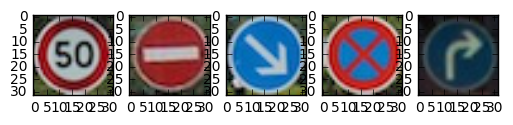

In [15]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

my_images = os.listdir("my_images/")
num_images = len(my_images)
i = 0
for image_file in my_images:
    i = i + 1
    plt.subplot(100 + 10*num_images + i)
    image = mpimg.imread('my_images/' + image_file)
    plt.imshow(image)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

The images which I am using are pictures of signs which I have taken while visiting Germany. I don't know if all of these classes of signs are in the dataset, but, I think that at least some of them should be. If the dataset does not include the class for one of these signs, it will be impossible for the network to classify it properly. Additionally, based on the images of the features in the dataset in the Data Exploration step of this report, it seems like the bounding boxes around the traffic signs in the dataset have more padding than in my images. In my images, the traffic signs fill the largest possible circle in the 32x32 pixel space. I believe the convolutional and pooling layers should provide some translational invariance, but likely limited scale invariance. 

In [18]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

def features_from_image_path(image_path):
    img_data = mpimg.imread(image_path)
    return np.array(normalize_greyscale(grayscale(img_data)))

my_images = os.listdir('my_images/')
with tf.Session() as sess:
    #sess.run(init)
    saver = tf.train.import_meta_graph('trained_model_2b.ckpt.meta')
    saver.restore(sess, 'trained_model_2b.ckpt')
    for image_path in my_images:
        img_features = features_from_image_path('my_images/' + image_path)
        img_features = np.expand_dims(img_features,0)
        img_features = np.expand_dims(img_features,3)
        predicted_class = sess.run(tf.argmax(logits, 1),feed_dict={x:img_features})
        print("image path: ", image_path," predicted class: ", predicted_class)

image path:  50kph.jpg  predicted class:  [2]
image path:  dne.jpg  predicted class:  [17]
image path:  down_right_arrow.jpg  predicted class:  [38]
image path:  red_x_raw.jpg  predicted class:  [4]
image path:  right_turn_raw.jpg  predicted class:  [33]


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

Filename | Predicted Class | Predicted Class Name

50kph.jpg | 2 | Speed limit (50km/h)

dne.jpg | 17 | No entry

down_right_arrow.jpg | 38 | Keep right

red_x_raw.jpg | 4 | Speed limit (70km/h)

right_turn_raw.jpg | 33 | Turn right ahead

I think that my model correctly classified signs 1,2,3, and 5. I don't know exactly what sign 4 even means and its class might not be in the dataset. Based on these results (roughly 80% accuracy), I believe that it is performing equally well on captured pictures

In [17]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
my_images = os.listdir('my_images/')
with tf.Session() as sess:
    #sess.run(init)
    saver = tf.train.import_meta_graph('trained_model_2b.ckpt.meta')
    saver.restore(sess, 'trained_model_2b.ckpt')
    for image_path in my_images:
        img_features = features_from_image_path('my_images/' + image_path)
        img_features = np.expand_dims(img_features,0)
        img_features = np.expand_dims(img_features,3)
        top_k_classes = sess.run(tf.nn.top_k(tf.nn.softmax(logits),k=5),feed_dict={x:img_features})
        print("top_k classes: ", top_k_classes)

top_k classes:  TopKV2(values=array([[ 0.76803219,  0.13529322,  0.05029874,  0.01713385,  0.0138288 ]], dtype=float32), indices=array([[ 2,  7,  8, 16,  5]], dtype=int32))
top_k classes:  TopKV2(values=array([[  9.99961257e-01,   3.53984724e-05,   1.78912762e-06,
          3.91884384e-07,   3.66161629e-07]], dtype=float32), indices=array([[17, 14, 32,  1,  4]], dtype=int32))
top_k classes:  TopKV2(values=array([[  9.99968886e-01,   1.22552565e-05,   1.04344717e-05,
          6.99244401e-06,   6.14251860e-07]], dtype=float32), indices=array([[38, 36, 20,  5,  3]], dtype=int32))
top_k classes:  TopKV2(values=array([[ 0.72871488,  0.14048967,  0.12163063,  0.00454944,  0.0026562 ]], dtype=float32), indices=array([[ 4,  1,  0, 17, 32]], dtype=int32))
top_k classes:  TopKV2(values=array([[  9.99969840e-01,   1.75025380e-05,   5.82653092e-06,
          3.42213252e-06,   1.02509489e-06]], dtype=float32), indices=array([[33, 11, 37, 39, 35]], dtype=int32))


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

The model is very confident in the prediction for the first sign. For signs 2,3, and 5, it is rougly 10% certain that it chose the correct sign, but it places several orders of magnitude greater probability on its first class choice than its second class choice. For sign 4, the probability distribution primarily includes 3 speed limit signs.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.